# Problem: Are blocked driveways complaints associated with more traffic tickets per capita (DOF Parking Violations and Census)

## Import necessary libraries

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import usaddress
from address import AddressParser, Address
import random
import statsmodels.formula.api as smf
pd.options.display.max_rows = 2000
plt.style.use('ggplot')
from PIL import Image

%matplotlib inline

## Read our 311 data csv file (Already wrangled)

In [16]:
data = pd.read_csv('311_Service_Requests_from_2014_to_Present.csv')

In [17]:
data.columns

Index([u'Created Date', u'Complaint Type', u'Incident Zip',
       u'Incident Address', u'Street Name', u'Latitude', u'Longitude',
       u'Location'],
      dtype='object')

In [18]:
df = data[['Complaint Type','Street Name','Incident Address','Incident Zip','Location']]

In [19]:
# create csv files for GIS
zip = df.groupby(['Incident Zip']).size()
zip = pd.DataFrame({'zipcode':zip.index,'counts':zip.values})
zip.to_csv('zip.csv')

In [20]:
data[['Latitude','Longitude']].to_csv('location.csv')

# Visualization

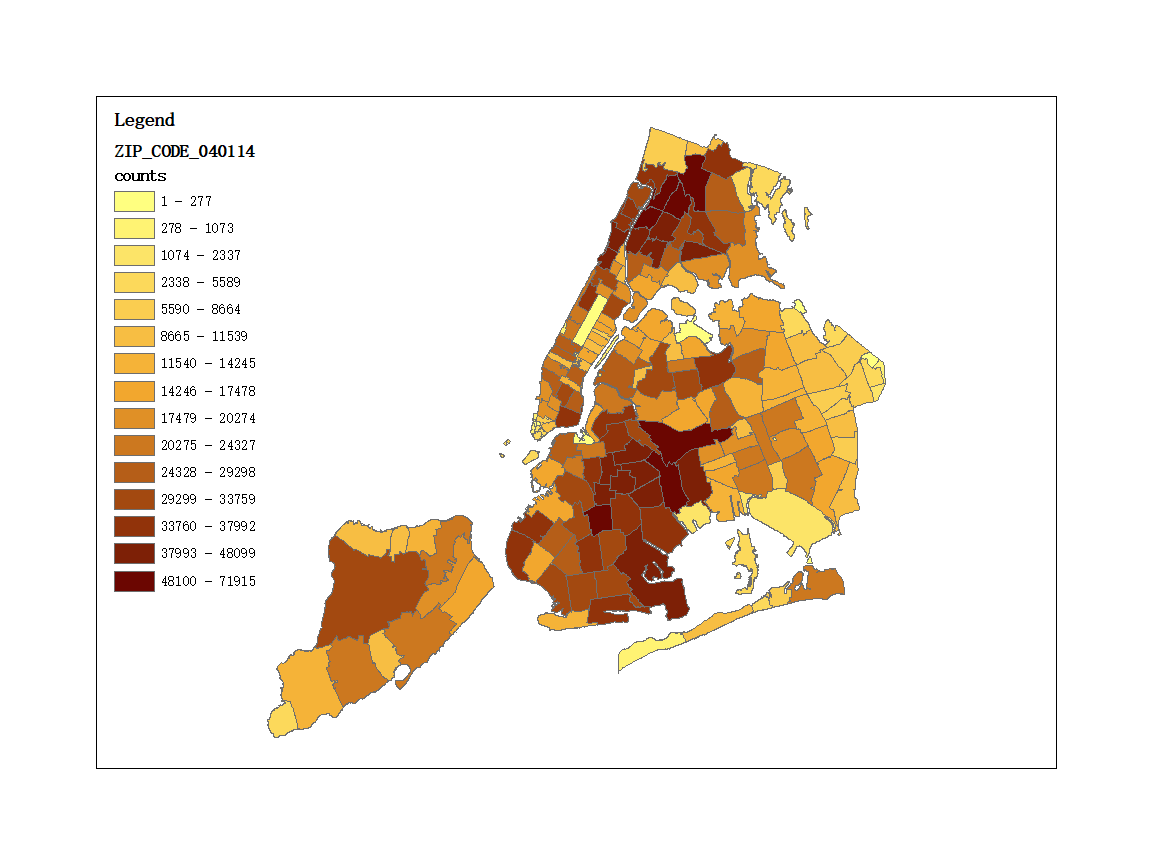

In [21]:
image = Image.open('GIS.png')
display(image)

In [22]:
# extract the dataframe we need to another csv file
df.to_csv('311.csv')

In [23]:
df = pd.read_csv('311.csv')

In [24]:
# Extract the information of the 'Blocked Driveway' complaints
df1 = df[df['Complaint Type']=='Blocked Driveway']

In [25]:
# read the violation tickets data
df2 = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2016.csv')

In [26]:
df2.head()

,Street Name
0,MACDOUNGH ST
1,LEXINGTON AVE
2,FULTON ST
3,MADISON ST
4,MADISON ST


In [27]:
df1.head()

,Unnamed: 0,Complaint Type,Street Name,Incident Address,Incident Zip,Location
0,0,Blocked Driveway,THAYER STREET,42 THAYER STREET,10040.0,"(40.86261768402197, -73.92654130847451)"
1,1,Blocked Driveway,121 STREET,85-29 121 STREET,11415.0,"(40.70282397189356, -73.82985109914424)"
2,2,Blocked Driveway,86 STREET,35-37 86 STREET,11372.0,"(40.751827151067, -73.88088723605281)"
3,3,Blocked Driveway,ANDERSON AVENUE,977 ANDERSON AVENUE,10452.0,"(40.83163065761848, -73.92766321026406)"
4,4,Blocked Driveway,FENTON AVENUE,3147 FENTON AVENUE,10469.0,"(40.87190832567398, -73.84571838645164)"


In [30]:
complaints = df1.groupby('Street Name').size()
tickets = df2.groupby('Street Name').size()

In [32]:
df_comp = pd.DataFrame({'Street Name':complaints.index,'n_complaints':complaints.values})
df_ticket = pd.DataFrame({'Street Name':tickets.index,'n_tickets':tickets.values})

In [34]:
df_comp = df_comp.dropna(0)
df_ticket = df_ticket.dropna(0);

## Generate descriptives for my variables of interests: "Blocked Driveways" complaints and violation tickets in NYC

# 1. "Blocked Driveways" complaints

In [53]:
df_comp.n_complaints.describe()

count    4958.000000
mean       23.551230
std        45.502175
min         1.000000
25%         2.000000
50%         5.000000
75%        22.000000
max       535.000000
Name: n_complaints, dtype: float64

In [37]:
df_comp.n_complaints.mean()

23.551230334812423

In [38]:
df_comp.n_complaints.median()

5.0

In [39]:
df_comp.n_complaints.std()

45.50217522127854

In [71]:
plt.rcParams['figure.figsize'] = 20, 10

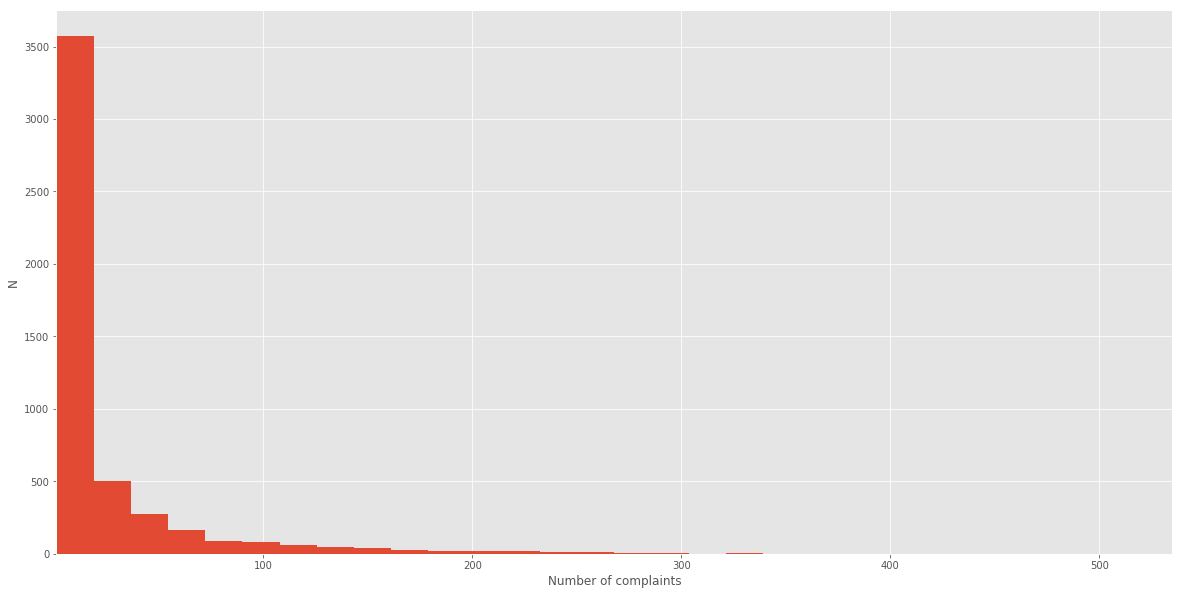

In [75]:
plt.hist(df_comp.n_complaints.values,bins=30)
plt.xlim([1,535])
plt.xlabel('Number of complaints')
plt.ylabel('N')
plt.show()

# 2. Violation tickets

In [79]:
df_ticket.n_tickets.describe()

count     94056.000000
mean        112.896838
std        1505.997059
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      210685.000000
Name: n_tickets, dtype: float64

In [80]:
df_ticket.n_tickets.mean()

112.89683805392532

In [81]:
df_ticket.n_tickets.median()

1.0

In [82]:
df_ticket.n_tickets.std()

1505.9970588801727

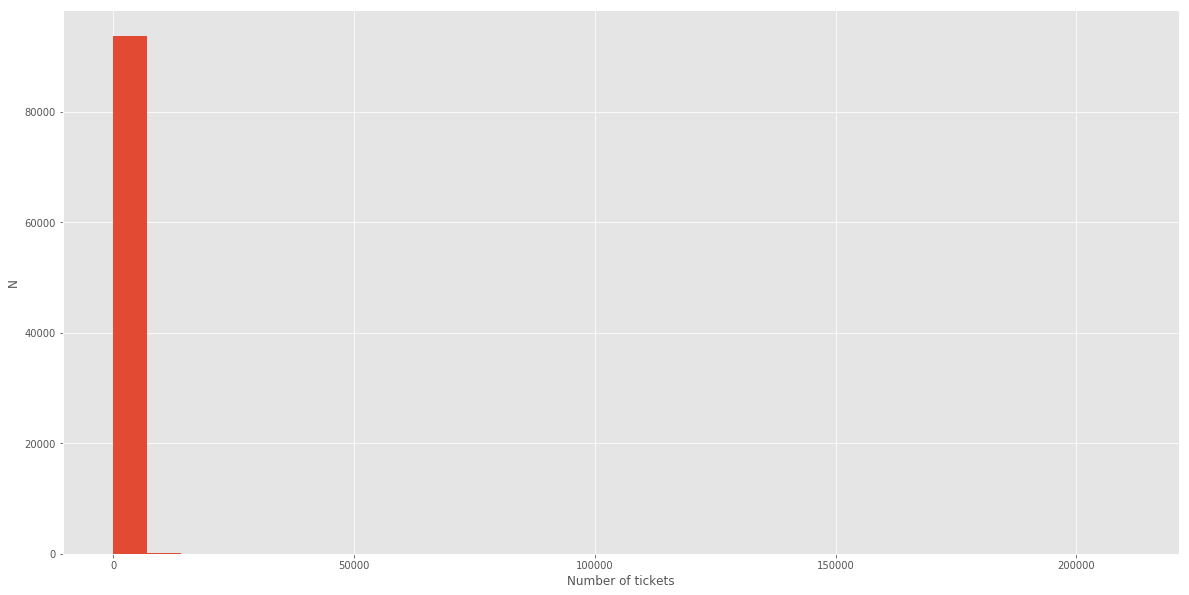

In [84]:
plt.hist(df_ticket.n_tickets.values,bins=30)
plt.xlabel('Number of tickets')
plt.ylabel('N')
plt.show()

# Analysis

In [85]:
# randomly pick 1000 rows in case of the memory error if in need
df_comp = df_comp.sample(1000)
df_ticket = df_ticket.sample(1000)

In [86]:
df1_st = []
for street in df_comp['Street Name']:
    addr = usaddress.parse(street)
    ad = AddressParser()
    addr2 = ad.parse_address(street)
    df1_st.append(' '.join(filter(None,([addr2.street_prefix,addr2.street,addr2.street_suffix]))))

In [87]:
df2_st = []
for street in df_ticket['Street Name']:
    addr = usaddress.parse(street);
    ad = AddressParser()
    addr2 = ad.parse_address(street)
    df2_st.append(' '.join(filter(None,([addr2.street_prefix,addr2.street,addr2.street_suffix]))))

Unmatched token:  @
Unmatched token:  @


In [88]:
df_comp['Street Name'] = df1_st
df_ticket['Street Name'] = df2_st

In [89]:
df = pd.merge(df_comp,df_ticket,on='Street Name',how='inner')

In [90]:
s = df['Street Name'].str.len().sort_values().index
df = df.reindex(s)

In [109]:
df=df[df['Street Name'].str.len()>df['Street Name'].str.len().min()]

In [111]:
df.head()

,Street Name,n_complaints,n_tickets
102,41 St.,257,83
122,36 Ave.,62,17
103,60 Ave.,61,22
113,142 St.,50,2
111,W. 7 St.,56,4


In [112]:
lm = smf.ols(formula='n_complaints~n_tickets',data=df).fit()

In [113]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           n_complaints   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     6.547
Date:                Mon, 09 Oct 2017   Prob (F-statistic):             0.0141
Time:                        15:36:04   Log-Likelihood:                -256.00
No. Observations:                  45   AIC:                             516.0
Df Residuals:                      43   BIC:                             519.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.8265     11.119      3.672      0.001      18.402      63.251
n_tickets      0.0115      0.005      2.559      0.014       0.002       0.021
==============================================================================
Omnibus:                       34.284   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.875
Skew:                           2.212   Prob(JB):                     9.09e-17
Kurtosis:                       7.453   Cond. No.                     2.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

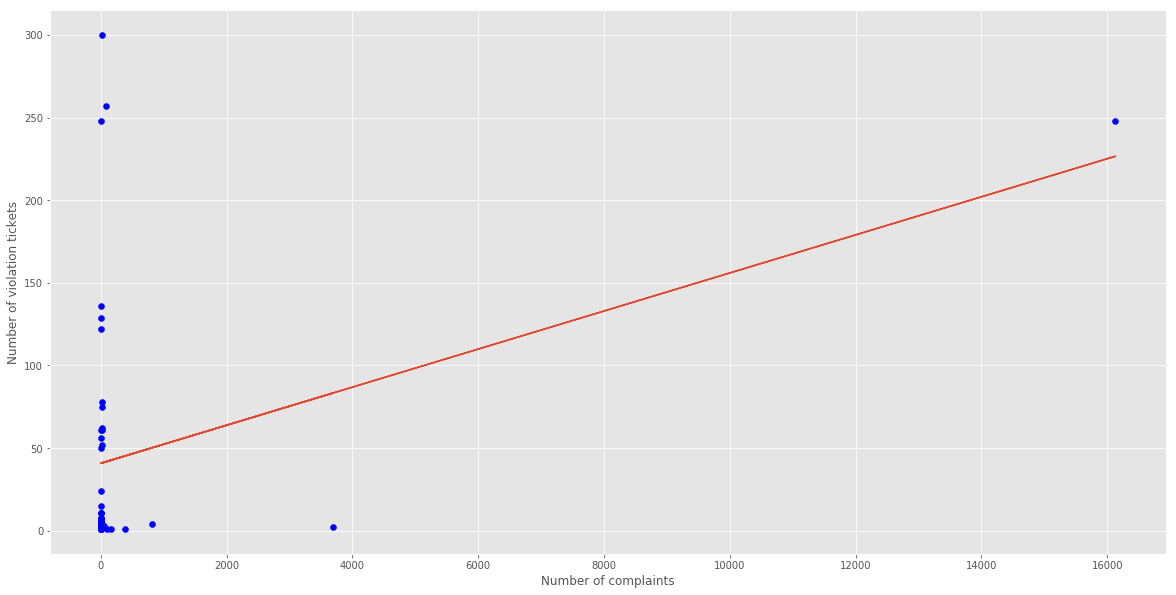

In [114]:
plt.scatter(df.n_tickets,df.n_complaints,c='b')
plt.plot(df.n_tickets,lm.predict())
plt.xlabel('Number of complaints')
plt.ylabel('Number of violation tickets')
plt.show()

## Seems like the correlation isn't that strong, let's try logatithm

In [115]:
df['log_comp'] = np.log(df.n_complaints)
df['log_tickets'] = np.log(df.n_tickets)

C:\Users\sddz0\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sddz0\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
lm_log = smf.ols(formula='log_comp~log_tickets',data=df).fit()

In [117]:
lm_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_comp   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.09799
Date:                Mon, 09 Oct 2017   Prob (F-statistic):              0.756
Time:                        15:37:12   Log-Likelihood:                -91.874
No. Observations:                  45   AIC:                             187.7
Df Residuals:                      43   BIC:                             191.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2410      0.381      5.887      0.000       1.473       3.009
log_tickets     0.0393      0.126      0.313      0.756      -0.214       0.292
==============================================================================
Omnibus:                       12.976   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                3.551
Skew:                           0.287   Prob(JB):                        0.169
Kurtosis:                       1.749   Cond. No.                         4.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

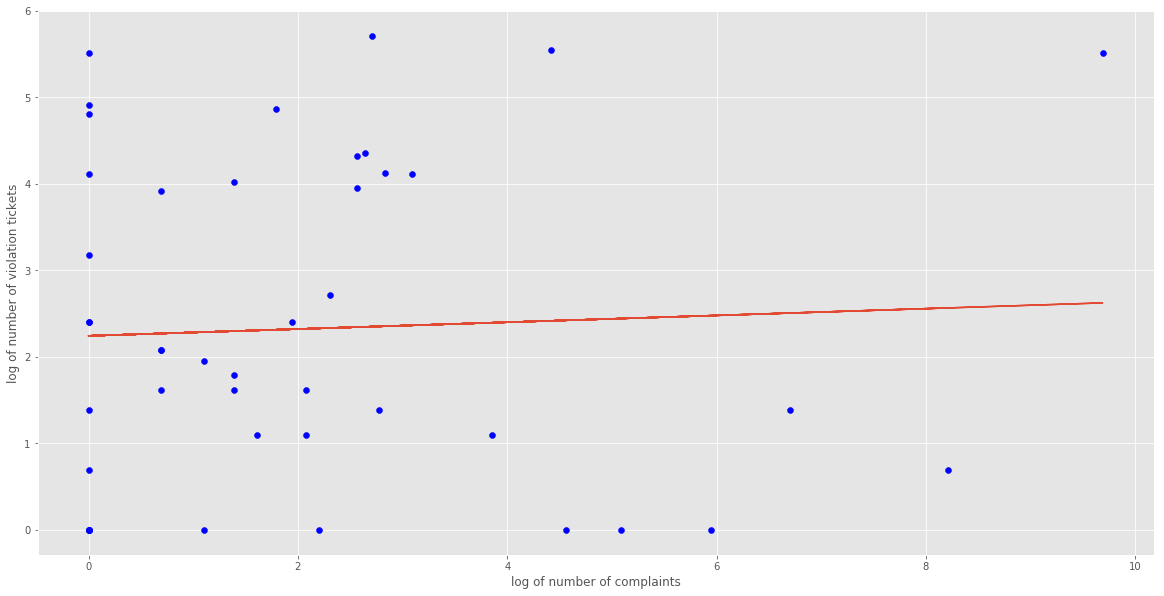

In [118]:
plt.scatter(df.log_tickets,df.log_comp,c='b')
plt.plot(df.log_tickets,lm_log.predict())
plt.xlabel('log of number of complaints')
plt.ylabel('log of number of violation tickets')
plt.show()

## The R Square became even smaller, so so far there isn't much correlation bewteen the two variables

In [123]:
df.columns

Index([u'Street Name', u'n_complaints', u'n_tickets', u'log_comp',
       u'log_tickets'],
      dtype='object')

## Let's try to find some outliers using boxplot

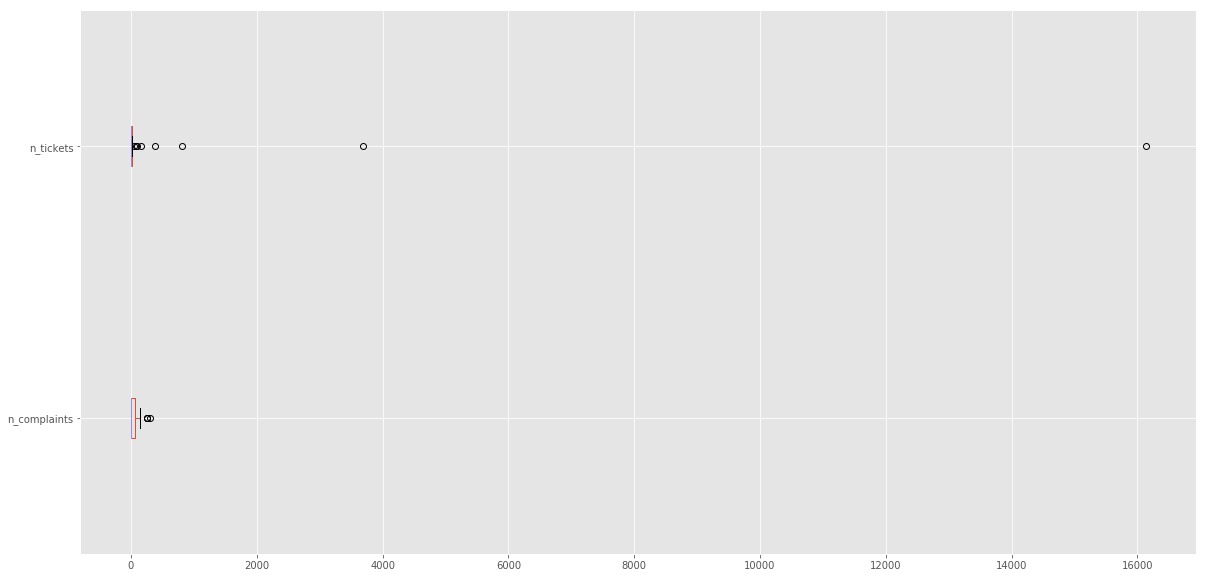

In [124]:
df[['n_complaints','n_tickets']].plot.box(vert=False)

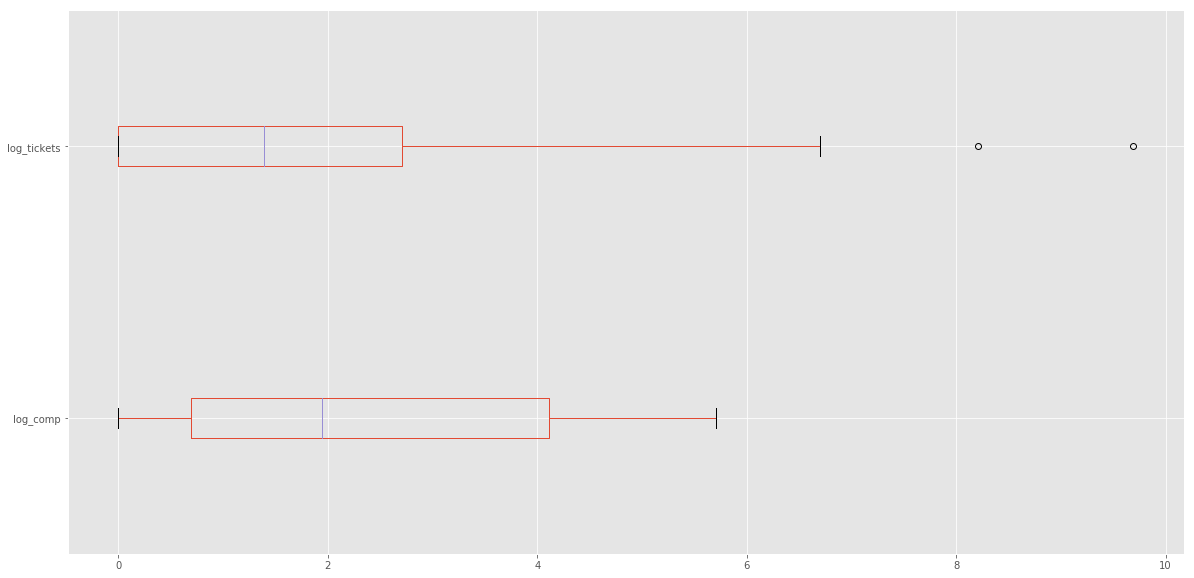

In [126]:
df[['log_comp','log_tickets']].plot.box(vert=False)

## There are some outliers in our log_tickets, let's find them

In [127]:
df_q = df[['log_comp','log_tickets']].quantile([0.25,0.75])
print(df_q)

      log_comp  log_tickets
0.25  0.693147      0.00000
0.75  4.110874      2.70805


In [131]:
# show the outlier
df[df['log_tickets']>df_q.iloc[1,1]+1.5*(df_q.iloc[1,1]-df_q.iloc[0,1])]

,Street Name,n_complaints,n_tickets,log_comp,log_tickets
4,Kings Hwy.,248,16132,5.513429,9.68856
24,Thompson St.,2,3688,0.693147,8.21284


## Looks like there are way more tickets on Kings Highway and Thompson Street.

## Discussion: Frome my findings, there isn't strong linear relationship between blocked roadway complaints and the numbers of violation tickets in that the R Square is only 0.132. However, this could be due to some of my data wrangling process. For example:
- I only chose 1000 samples out of my data because more would crash my kernel (Memory Error)
- The address name formats in two datasets are totally different because of manual input so I used a python library called Usaddress to match them. Nevertheless, there are still a lot of addresses couldn't be recogonized by the algorithms, though this is the best way for me so far.
## So I would recommend agencies involved develop a effective way to match addresses in different format and for me I shoule also figure out a same way to improve my approach.

## Agencies that could be involved: NYC DOT, NYPD